<a href="https://colab.research.google.com/github/letruong711/Breast_Cancer_and_Neural_Networks/blob/main/Breast_Cancer_CNN_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Mouting Google Drive.**

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Importing Libraries.**#

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import glob
import random

import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist

from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
import tensorflow_datasets as tfds

import datetime

#**Importing Data/Establishing Pathways.**

In [ ]:
#setting up bridge between collab and drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fid = drive.ListFile({'q': "title='updated_kaggle_breast.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id':fid})
f.GetContentFile('updated_kaggle_breast.zip')

In [ ]:
#unzip massive file.
!unzip updated_kaggle_breast.zip

In [ ]:
PATH = '/content/updated_kaggle_breast/IDC_regular_ps50_idx5'

In [ ]:
os.listdir(PATH)

In [ ]:
train_dir = os.path.join(PATH, 'Train')
test_dir = os.path.join(PATH, 'Test')

##Preprocessing.##

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
batch_size = 624

In [ ]:
image_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_data_gen = image_gen.flow_from_directory(
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size= 5216,
    class_mode='binary')

Found 20467 images belonging to 2 classes.


In [ ]:
test_data_gen = image_gen.flow_from_directory(
    directory = test_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = batch_size,
    class_mode='binary')

Found 6600 images belonging to 2 classes.


In [ ]:
cnn_train_images, cnn_train_labels = next(train_data_gen)
cnn_test_images, cnn_test_labels = next(test_data_gen)

In [ ]:
#making sure dimensions are correct for CNN
display(np.shape(cnn_train_images))
display(np.shape(cnn_train_labels))
display(type(cnn_train_images))
display(type(cnn_train_labels))

display(np.shape(cnn_test_images))
display(np.shape(cnn_test_labels))
display(type(cnn_test_images))
display(type(cnn_test_labels))

(5216, 224, 224, 3)

(5216,)

numpy.ndarray

numpy.ndarray

(624, 224, 224, 3)

(624,)

numpy.ndarray

numpy.ndarray

#**Creating CNN.**

In [ ]:
#drop out .3
def initialize_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Conv2D(192, (3, 3), activation="relu", padding='same'))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Conv2D(256, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
cnn = initialize_model()

In [ ]:
#compile CNN
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

In [ ]:
# This will stop training when the monitored metric has stopped improving
# This might be more useful when fine tuning a model

early_stopping = EarlyStopping(patience = 30,               
                               monitor = 'val_accuracy', 
                               restore_best_weights = True) 

# Patience = After 30 epochs with no improvement, training will be stopped
# Monitor = Binary Accuracy is the quantity being monitored for the patience level
# Restoring model weights from the epoch with the best value of the monitored quantity

In [ ]:
#run the model

history = cnn.fit(cnn_train_images, 
                    cnn_train_labels,
                    verbose = 2,
                    batch_size = 60, 
                    epochs = 300,
                    validation_data = (cnn_test_images, cnn_test_labels),
                    callbacks = [early_stopping])

Epoch 1/300
87/87 - 499s - loss: 1.0641 - accuracy: 0.5504 - val_loss: 0.6843 - val_accuracy: 0.5962 - 499s/epoch - 6s/step
Epoch 2/300
87/87 - 493s - loss: 0.6939 - accuracy: 0.4916 - val_loss: 0.6925 - val_accuracy: 0.5962 - 493s/epoch - 6s/step
Epoch 3/300
87/87 - 491s - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6940 - val_accuracy: 0.4038 - 491s/epoch - 6s/step
Epoch 4/300
87/87 - 492s - loss: 0.6931 - accuracy: 0.5084 - val_loss: 0.6948 - val_accuracy: 0.4038 - 492s/epoch - 6s/step
Epoch 5/300
87/87 - 490s - loss: 0.6929 - accuracy: 0.5084 - val_loss: 0.6957 - val_accuracy: 0.4038 - 490s/epoch - 6s/step
Epoch 6/300
87/87 - 490s - loss: 0.6927 - accuracy: 0.5084 - val_loss: 0.6953 - val_accuracy: 0.4038 - 490s/epoch - 6s/step
Epoch 7/300
87/87 - 489s - loss: 0.6695 - accuracy: 0.5834 - val_loss: 0.5155 - val_accuracy: 0.6266 - 489s/epoch - 6s/step
Epoch 8/300
87/87 - 489s - loss: 0.4730 - accuracy: 0.7847 - val_loss: 0.5187 - val_accuracy: 0.7692 - 489s/epoch - 6s/step
Epoch 9/

##**# Visualizing our Loss/Accuracy Curves, Classification Report, Confusion Matrices.**

In [ ]:
def visualize_training_results(results, model, test_images, test_labels):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
       
    y_hat_test = model.predict(test_images)
    thresh = 0.5
    y_pred = (y_hat_test > thresh).astype(np.int)
    y_true = test_labels.astype(np.int)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '0.5g')
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y_true, y_pred))
    print('\n')
    print('\n')
    print('Evaluating the Performance')
    print('\n')
    
    test_score = model.evaluate(test_images, test_labels, verbose = 0)
    print(f'Test Loss: {test_score[0]}')
    print(f'Test Accuracy: {test_score[1]}')

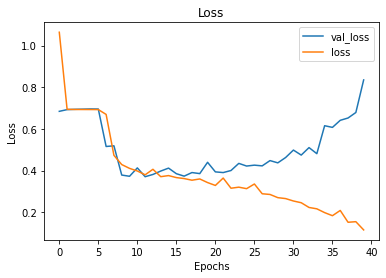

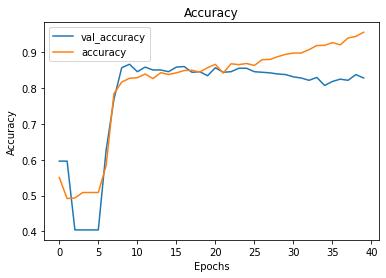

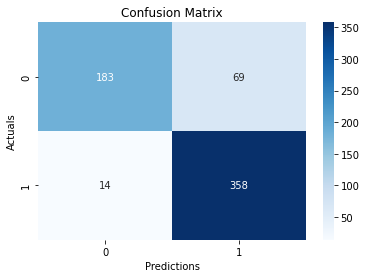

              precision    recall  f1-score   support

           0       0.93      0.73      0.82       252
           1       0.84      0.96      0.90       372

    accuracy                           0.87       624
   macro avg       0.88      0.84      0.86       624
weighted avg       0.87      0.87      0.86       624





Evaluating the Performance


Test Loss: 0.3723932206630707
Test Accuracy: 0.8669871687889099


In [ ]:
visualize_training_results(history, cnn, cnn_test_images, cnn_test_labels)

#**Results.**

In [ ]:
- Model was able to achieve 87% accuracy.
  - After 25 epochs, model shows starts under performing.
- Overall decent model with only 69% false positives.